# Shelter Animal Outcomes
### Talieh, John, Sean, Subhashini

In [1]:
%matplotlib inline

from datetime import date, datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import cross_validation

from patsy import dmatrices, dmatrix

pd.set_option('display.max_columns', None)

In [2]:
train_data = pd.read_csv('train.csv', parse_dates=['DateTime'])
test_data = pd.read_csv('test.csv', parse_dates=['DateTime'])

n_train_data = len(train_data.index)

## 1. Data Exploration

### Data Description

The provided data consists of the following fields:

* **AnimalID:** An ID for each animal. Used for identifying results when making submissions to Kaggle.

* **Name:** The name of each animal, if any.

* **DateTime:** The date and time _on which the outcome occurred._ The date or time on which the animal was received by the shelter is not included in the data set.

* **OutcomeType (train only):** The outcome we are trying to predict. There are four possible outcomes: adoption, transfer (e.g., to a rescue or another shelter), return to owner, euthanasia, or death for other reasons.

* **OutcomeSubtype (train only):** More details on the nature of the outcome. This column is not included in the test set, and we are not scored for predicting it, so we generally ignored it.

* **AnimalType:** Whether the animal is a dog or a cat.

* **SexuponOutcome:** This feature contains information about both the animal's sex, and whether it has been spayed or neutered at the time of the outcome. The value may be NA.

* **AgeuponOutcome:** The animal's age at the time of outcome, given as an integral number of days, weeks, months or years. The value may be NA.

* **Breed:** The animal's breed. In the case of mixed breeds, it will be denoted as either a combination of two breeds separated by a slash ("Dachshund/Beagle"), or a single breed followed by the word Mix ("Domestic Shorthair Mix"). The value may be NA.

* **Color:** The animal's color and color pattern. It may be a singe color ("Tan") or two colors separated by a slash ("Brown/White"), plus an optional word describing the color pattern ("Orange Tabby", "Black/White Point").

In [3]:
train_data.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
# Utility functions
# From: http://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('4-winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('1-spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('2-summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('3-autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('4-winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

### Combining the training and submission data.

For the sake of simplicity in data exploration and feature engineering, we are combining the train and test data into a single data frame to operate on for feature engineering, and then separating it back out again before training and testing. Jupyter notebooks are more manageable if most the work is done in a global scope, and that way of working doesn't lend itself as well to keeping the sets separate because we would then need to worry about managing state in a way that lets us apply our feature engineering to both data sets separately while still staying coherent.

In real life this should not be done because it will adversely impact the generalizability of the data. However, the Kaggle competition is already different from real life in many ways. Generalizing well to future data is not one of the goals, so the test set is not a tool for estimating how accurate the model will be on future data the way it would be in a real-world situation. Instead, the test set is an end in and of itself, and any concerns about the validity of the test set score are tangential at best. Furthermore, the train and test sets include some variables that can only be known after the outcome has already been determined: The date and time of the outcome, the animal's age when the outcome occurs, and possibly also whether or not the animal has been spayed or neutered at the time of the outcome.

For Kaggle purposes it may also help our score in cases where the distributions of some variables differ between the train and test sets. In practice we did not find any significant differences, but it was a consideration.

In [5]:
feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color', 'OutcomeType']

train_features = train_data.loc[:, feature_columns]
test_features = test_data.loc[:, feature_columns]

data = pd.concat((train_features, test_features), ignore_index=True)

In [6]:
data['Season'] = data.DateTime.map(get_season)

data['Sex X Species'] = data.SexuponOutcome + ' ' + data.AnimalType

data['Month'] = data.DateTime.apply(lambda d: d.strftime('%m-%B'))   # 'January', 'Feburary', . . .
data['WeekDay'] = data.DateTime.apply(lambda d: d.strftime('%w-%A')) # 'Sunday', 'Monday', . . .  

In [7]:
train_data = data[:n_train_data]
test_data = data[n_train_data:]

print 'Size of training set: %d' % len(train_data.index)
print 'Size of submission set: %d' % len(test_data.index)

Size of training set: 26729
Size of submission set: 11456


### Comparing train and test data distributions

In [8]:
train_data.describe()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,Season,Sex X Species,Month,WeekDay
count,26729,19038,26729,26729,26728,26711,26729,26729,26729,26729,26728,26729,26729
unique,26729,6374,22918,2,5,44,1380,366,5,4,10,12,7
top,A705677,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Adoption,3-autumn,Neutered Male Dog,10-October,6-Saturday
freq,1,136,19,15595,9779,3969,8810,2824,10769,7777,6714,2881,4348
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Utility functions for plotting

In [9]:
# Function to plot bar charts of categorical variables, with 
# train and test bars side-by-side. Hard-coded to use data from global env
def barplot_testvtrain(field_name):
    train_size = len(train_data.index) * 1.0
    test_size = len(test_data.index) * 1.0

    train_dist = train_data.groupby(field_name).size() / train_size
    test_dist = test_data.groupby(field_name).size() / test_size
    
    indices = np.arange(train_dist.size)
    width = .35
    
    fig, ax = plt.subplots()
    plt.title('{} distribution'.format(field_name))
    
    train_rects = ax.bar(indices, train_dist, width, color='r')
    test_rects = ax.bar(indices + width, test_dist, width, color='b')

    ax.set_xticks(indices + width)
    ax.set_xticklabels(train_dist.index, rotation=45)

    ax.legend((train_rects[0], test_rects[0]), ('Train', 'Test'), loc=0)
    plt.show()
    
# Function to generate stacked bar charts of outcome v. categorical variable,
# hard-coded to use data from global env
def barplot_stacked(field_name, rescale=True):
    # Making a copy of the data to use for plotting.
    # Copy is needed 'cuz I'm dropping NAs.
    plot_data = pd.DataFrame()
    plot_data[field_name] = train_data[field_name]
    plot_data['OutcomeType'] = train_data.OutcomeType
    plot_data = plot_data.dropna()

    # List of outcomes in order to stack, together with assigned color
    outcomes = [('Adoption', 'r'), 
                ('Transfer', 'b'), 
                ('Return_to_owner', 'g'), 
                ('Euthanasia', 'y'), 
                ('Died', 'm')]

    # Getting information about the categories in the variable
    categories = plot_data[field_name].unique()
    categories.sort()
    cat_counts = plot_data.groupby(field_name).size()
    indices = np.arange(categories.size)
    
    width = .75
    barsets = []
    
    # Series of 0s for all categories, added to distributions
    # to ensure that there's an entry for every category.
    zero = pd.Series({c:0 for c in categories})
    # Keeps track of bottoms. Bottoms are just top of previous one.
    bottoms = pd.Series({c:0 for c in categories})

    fig, ax = plt.subplots()
    if(rescale):
        plt.title('Outcome rates by {}'.format(field_name))
    else:
        plt.title('Outcomes by {}'.format(field_name))

    # Loop over outcomes, generate bars, and stack them
    for outcome, c in outcomes:
        dist = plot_data.loc[plot_data.OutcomeType == outcome] \
                         .groupby(field_name) \
                         .size()
        if(rescale):
            dist = dist / cat_counts
                    
        dist = zero.add(dist, 'index', fill_value=0.0)

        # Saving barset for later because it's needed to draw the legend
        bs = ax.bar(indices, dist, width, color=c, bottom = bottoms)
        barsets.append(bs)
        
        # The bottom of the next round of bars will be the top of this one.
        bottoms = bottoms.add(dist, 'index', fill_value=0.0)

    # Drawing category labels
    ax.set_xticks(indices + (width / 2))
    ax.set_xticklabels(categories, rotation=90)
    
    if(rescale):
        ax.set_ylim(0, 1)
    # Drawing legend outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend([bs[0] for bs in barsets], 
              [n[0] for n in outcomes], 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    plt.show()

### Comparing the training to the submission data to see if they are balanced.

Overall the distributions of the key variables we are using are roughly the same between the test and train sets. This gives us some confidence that we don't need to worry much about extrapolation.

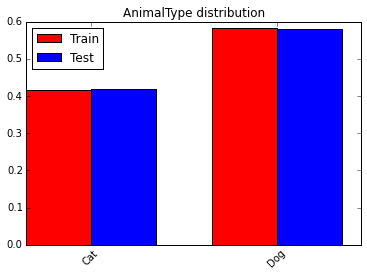

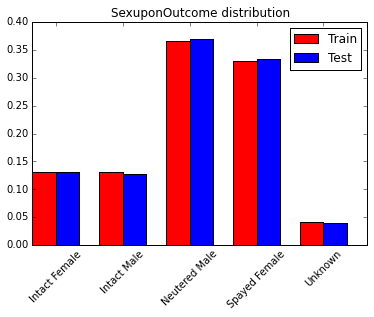

In [10]:
barplot_testvtrain('AnimalType')
barplot_testvtrain('SexuponOutcome')

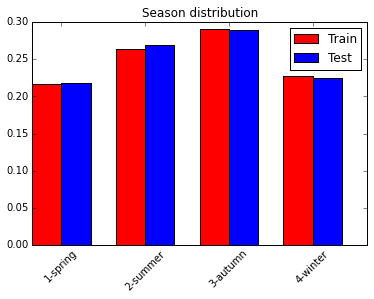

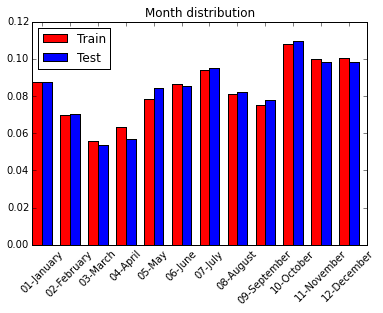

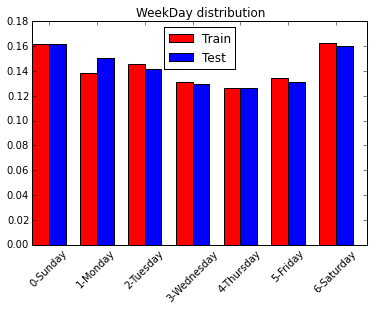

In [11]:
barplot_testvtrain('Season')
barplot_testvtrain('Month')
barplot_testvtrain('WeekDay')

### Are there any immediately apparent trends in the data?

Some initial analysis of the data indicates a number of predictive relationships. For example, while adoption and euthanasia rates are roughly the same for both species, cats are much more likely to be transferred and dogs are much more likely to be reunited with their owners.

We don't see huge differences based on sex, but, not surprisingly, whether or not an animal has been fixed is strongly correlated with outcomes. Intact animals are vastly less likely to be adopted, possibly because of the additional cost of needing to buy the surgery if one adopts an intact animal. Possibly as a result,t hey are also much more likely to be euthanized. On the other hand, their chances of being transferred are vastly greater. It's uncertain why this should be, but one could speculate that it's because the shelter is not equipped to perform spay or neuter operations, and is transferring them to a facility that is.

Digging a little deeper, we also find that for certain outcomes sex has a differential impact betwen the two species. For dogs, being intact has little impact on likelihood of being reunited with the owner. For intact cats, though, the odds of being reunited with an owner are effectively nil.

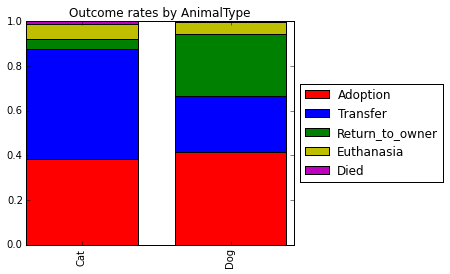

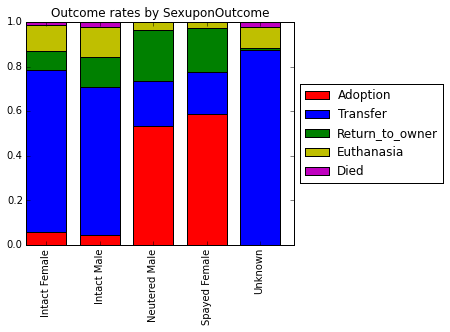

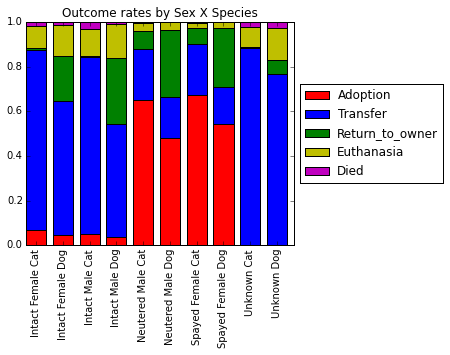

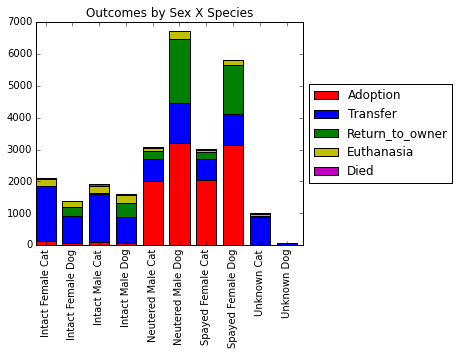

In [12]:
barplot_stacked('AnimalType')
barplot_stacked('SexuponOutcome')
barplot_stacked('Sex X Species')
barplot_stacked('Sex X Species', rescale=False)

We also find some evidence of seasonality in the data. The per-season data indicates that adoption rates steadily increase, and transfer rates steadily decline, as the year progresses. The pattern largely persists when we look look at things on a monthly basis, but the cyclical pattern becomes more apparent.. On that scale there appears to be a distinct lull in adoptions in the spring, and a lesser one in the autumn.

Unsurprisingly, looking at things by day of week reveals that people are more likely to adopt on the weekends. The relative likelihood of transfer diminishes. The absolute number of reunitings is roughly constant throughout the week, but the relative likelihood diminishes due to the large spike in weekend adoptions.

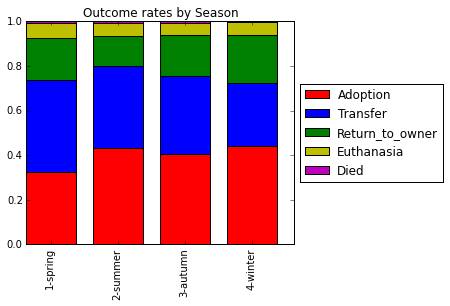

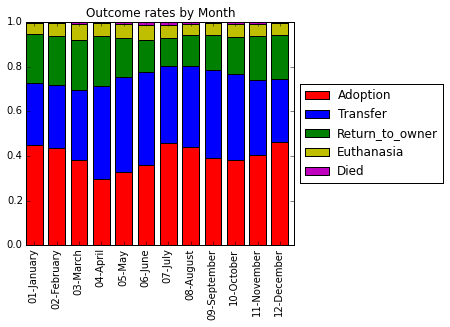

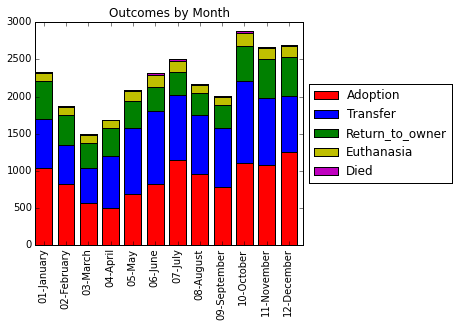

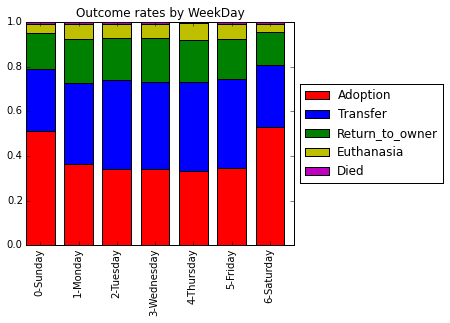

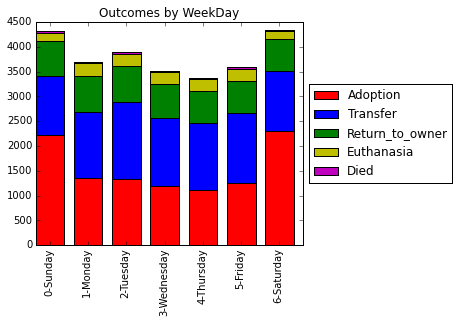

In [13]:
barplot_stacked('Season')
barplot_stacked('Month')
barplot_stacked('Month', rescale=False)
barplot_stacked('WeekDay')
barplot_stacked('WeekDay', rescale=False)

## 2. Feature Selection and Model Testing

### Multiple approaches to feature engineering were attempted

**Common Utility Functions**

In [14]:
# Converts age to a # of years, or returns NA if input is NA
def age_years(x):
    # We want to skip nan's
    try:
        age = int(x.split(' ')[0])

        if 'month' in x:
            age /= 12.0

        elif 'week' in x:
            age /= 52.0

        elif 'day' in x:
            age /= 365.0

        else:
            age = float(age)

        return age
    except AttributeError:
        return x

def draw_cm(y_true, y_pred,label_names):
    
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cm)
    
# use K-fold cross validation with k=6

def fit_model(clf):
    labels =  train_labels.cat.categories
    
    kf = KFold(train_data.shape[0], n_folds=6)

    ypp = []
    mll = []
    idx = 0
    for train_index, test_index in kf:
        X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
        y_train, y_test = train_labels.iloc[train_index], train_labels.iloc[test_index]
        #print X_train.shape, X_test.shape
        clf.fit(X_train, y_train)
        ypp.append(clf.predict_proba(X_test))
        mll.append(metrics.log_loss(y_test, ypp[idx]))
        idx += 1

    print "Log Loss (each iteration) :\n", '\n'.join([str(x) for x in mll])
    print "Std Deviation Log Loss :\n", np.std(mll)
    
    # Get the highest probability value
    y_pred = labels[np.argmax(np.vstack(ypp), axis=1)]
    
    print metrics.classification_report(train_labels, y_pred)
    draw_cm(train_labels, y_pred, labels)
    
def draw_rf_importances(clf, n_features = 50):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    print 'Top features: '
    print train_data.columns.values[indices[:n_features]]

    # We have some many features let's 
    # just look at the first n_features
    plt.figure(figsize=(10,10))
    plt.title("Feature importances, first %d" % n_features)
    plt.bar(range(n_features),
            importances[indices][:n_features],
            color="g",
            yerr=std[indices][:n_features],
            align="center")

    plt.xticks(range(n_features), indices, rotation=70)

    plt.xlim([-1, n_features])
    plt.xlabel('Feature Indices')
    plt.grid()
    plt.show()

### This is common to all the approches to creating features

In [15]:
# read in fresh train and test data
train = pd.read_csv('train.csv', parse_dates=['DateTime'])
test = pd.read_csv('test.csv', parse_dates=['DateTime'])

# get number of training elements
train_num = train.shape[0]

train.rename(columns={'AnimalID': 'ID'}, inplace=True)
all_data = pd.concat((train, test), axis=0, ignore_index=True)


# This is to make use of the fit_model function above without too much modification.
train_labels = pd.DataFrame(train['OutcomeType'], dtype='category')['OutcomeType']

## Feature Engineering

We tried many things for feature engineering, with varying levels of success. The following set contains just the ones that worked out well for us in the final model.

## Differences between feature sets:


| Original Field | FSV1                                                     | FSV2                                                                       | ***FSV3 (This)***                                                                                                               |
|----------------|----------------------------------------------------------|----------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| Name           | Ignored                                                  | Binary if name exists.                                                     | Binary if name exists.                                                                                             |
| DateTime       | Dummy coded as season.                                   | Split into Season, Month, WeekOfYear, WeekDay, Hour, AmPM and dummy coded. | Split into Season, Month, WeekOfYear, WeekDay, Hour, AmPM and dummy coded.                                         |
| AnimalType     | Binary                                                   | Binary                                                                     | Binary                                                                                                             |
| SexuponOutcome | Split into gender and fixed or not, both binary          | Dummy coded                                                                | Dummy coded                                                                                                        |
| AgeuponOutcome | Transformed into years and split into quartiles.         | Split into separate categories for dogs and cats.                          | Split into separate categories for dogs and cats. Split into separate categories for dogs and cats.                |
| Breed          | Split into primary and secondary breed then dummy coded. | Split into purebreed, mixed, etc. then dummy coded using countvectorizer.  | Split into primary and secondary breed and then dummy coded. Whether mix or not extracted as binary.               |
| Color          | Split into primary and secondary color and dummy coded.  | Dummy coded using countvectorier.                                          | Color modifiers extracted, merle/tick/tabby/brindle/point, along with primary and secondary color and dummy coded. |

In [16]:
fs = pd.DataFrame()

# ID
fs['ID'] = all_data['ID']

#### Name

The only thing we did with name was code a feature for whether or not the animal has a name. 

In [17]:
# Name

fs['HasName'] = all_data.Name.notnull()

#### DateTime

The date and time on which the outcome occurred where highly correlated with the type of outcome. This isn't too surprising - some outcomes are related to the shelter's operations so we expect them to be more likely during business hours. On the other hand, it also makes sense that people would be more likely to adopt an animal on evenings or weekends.

We coded variables for every major division of time between years and hours. Ultimately, they all ended up helping the model.

In [18]:
# Date

fs['Season'] = all_data.DateTime.map(get_season)
fs['Month'] = all_data.DateTime.apply(lambda d: d.strftime('%B')) # Full name of month
fs['WeekOfYear'] = all_data.DateTime.apply(lambda d: d.strftime('%U')) # Week of the year
fs['WeekDay'] = all_data.DateTime.apply(lambda d: d.strftime('%A')) # Full name of day
fs['Hour'] = all_data.DateTime.apply(lambda d: d.strftime('%H'))
fs['AmPm'] = all_data.DateTime.apply(lambda d: d.strftime('%p'))

#### AnimalType

There isn't much that needs to be done with this feature, so we just copy it over.

In [19]:
# AnimalType

fs['AnimalType'] = all_data.AnimalType

#### SexuponOutcome

This feature is really a combination of two orthogonal characteristics, and in intial versions we would manually break it out into separate dummy variables. However, there's not really any need to do that. Just dummy coding its four levels (five, if you count 'Unknown') as they are already presented is equivalent to coding separate features for 'Sex' and 'IsFixed' plus an interaction term for 'Sex * IsFixed'.

There was one null value in the source data, which we re-coded to 'Unknown'.

In [20]:
# SexuponOutcome

fs['Sex'] = all_data.SexuponOutcome
fs.loc[fs.Sex.isnull(), 'Sex'] = 'Unknown'

#### AgeuponOutcome

This variable was highly predictive of many categories, but the relationship was non-linear in most cases, and exact shape of the odds curve was different for each outcome.

Because of this we opted for coding it two ways: First, we just converted the age to years in order to get it into a numeric variable. We also experimented with normalizing this feature, but it didn't seem to help signficantly for logistic regression, and wasn't really necessary for random forests.

We also created categorical variables describing the "life stage" of the animal. Separate thresholds were created for dogs and cats, since they age differently. This allowed us to capture the nature of the relationships in a nonparametric manner.

In [21]:
# AgeuponOutcome

fs['AgeYears'] = all_data.AgeuponOutcome.map(age_years)

#create cat and dog age categories 
#source - http://www.akc.org/learn/family-dog/how-to-calculate-dog-years-to-human-years/
#http://icatcare.org/advice/how-guides/how-tell-your-cat%E2%80%99s-age-human-years
age_labels_dogs=['baby', 'adolescent', 'adult', 'senior']
age_ranges_dogs=[0.0, 1.0, 2.0, 7.0, 30.0]
age_ranges_cats=[0.0, 0.5, 2.0, 6.0, 10.0,15.0, 30.0]
age_labels_cats=['baby', 'adolescent', 'adult','mature', 'senior', 'geriatric']


#compute the dog age and cat age categories separately, then merge them
fs['dog_ages'] = pd.cut(fs['AgeYears'][fs['AnimalType']=='Dog'], age_ranges_dogs,  labels=age_labels_dogs)
fs['cat_ages'] = pd.cut(fs['AgeYears'][fs['AnimalType']=='Cat'], age_ranges_cats,  labels=age_labels_cats)
#merge
fs['AgeCategory'] = [fs['dog_ages'][x] 
                               if not pd.isnull(fs['dog_ages'][x]) 
                               else fs['cat_ages'][x] 
                                   for x in range(fs['dog_ages'].size)]

# Drop the temp columns
fs.drop(['dog_ages', 'cat_ages'], axis=1, inplace=True)

fs.loc[fs.AgeYears.isnull(), 'AgeYears'] = 0
fs.loc[fs.AgeCategory.isnull(), 'AgeCategory'] = 'Unknown'

In [22]:
# Breed

fs['IsMix'] = all_data.Breed.str.contains('Mix|/')
fs['CleanBreed'] = all_data.Breed.str.replace(' Mix', '')
fs['BreedBits'] = fs.CleanBreed.str.split('/')
fs['Breed1'] = fs.BreedBits.str[0]
fs['Breed2'] = fs.loc[fs.CleanBreed.str.contains('/')].BreedBits.str[1]
fs.loc[(fs.Breed2.isnull()), 'Breed2'] = 'None'

fs.drop(['CleanBreed', 'BreedBits'], axis=1, inplace=True)

#### Color
In the original dataset color was often represented as a compound color, Brown/White for instance. Initially we tried simply breaking this into color 1 and color 2 and dummy coding.

After the initial experimentation the original data was further split to remove certain color adjectives into their own feature. Merle, Tick, Tabby, Brindle, Point, and Tiger and then to split the Original color column into the primary and secondary colors.

In [23]:
# Color

# Pulling out separate features for merle/tick/tabby/brindle/point
fs['IsMerle'] = all_data.Color.str.contains('Merle')
fs['IsTick'] = all_data.Color.str.contains('Tick')
fs['IsTabby'] = all_data.Color.str.contains('Tabby')
fs['IsBrindle'] = all_data.Color.str.contains('Brindle')
fs['IsPoint'] = all_data.Color.str.contains('Point')
fs['IsTiger'] = all_data.Color.str.contains('Tiger')

# Then remove them
fs['CleanColor'] = all_data.Color.str.replace(' (Merle|Tick|Tabby|Brindle|Point|Tiger)', '')
fs['ColorBits'] = fs.CleanColor.str.split('/')

# And split to get rest
fs['Color1'] = fs.ColorBits.str[0]
fs['Color2'] = fs.loc[fs.CleanColor.str.contains('/')].ColorBits.str[1]
fs.loc[(fs.Color2.isnull()), 'Color2'] = 'None'

fs.drop(['CleanColor', 'ColorBits'], axis=1, inplace=True)

In [24]:
fs.head(2)

,ID,HasName,Season,Month,WeekOfYear,WeekDay,Hour,AmPm,AnimalType,Sex,AgeYears,AgeCategory,IsMix,Breed1,Breed2,IsMerle,IsTick,IsTabby,IsBrindle,IsPoint,IsTiger,Color1,Color2
0,A671945,True,4-winter,February,06,Wednesday,18,PM,Dog,Neutered Male,1,baby,True,Shetland Sheepdog,None,False,False,False,False,False,False,Brown,White
1,A656520,True,3-autumn,October,41,Sunday,12,PM,Cat,Spayed Female,1,adolescent,True,Domestic Shorthair,None,False,False,True,False,False,False,Cream,None


## Dummy coding features and generating some interactions

The resulting data set consists of a mix of interval and categorical data. Numpy and Pandas both have functionality for dummy coding the categorical variables, but another library, Patsy, lets us do it efficiently while also supporting the generation of interaction variables.

Interactions first made it into our model when we were primarily working with logistic regression. Later on, when we switched to random forests, we found that removing the interactions reduced the accuracy of the model, so we have left them in.

To be honest, we don't fully understand why the interaction terms should help the random forests. Intuitively, any of these interactions should be something that the random forest can pick up on by making successive cuts on the two different variables. 

One possibilty is that it's an artifact of how we're handling breed and color. These two generate a very large set of dummy variables, which might result in them tending to overwhelm the other features when feature sets are being selected for the individual trees in the model. If so, then the interactions might serve as a way to re-weight the feature selection back toward some of the more predictive features.

In [25]:
fs_coded = dmatrix('AnimalType + HasName + Sex + AgeYears + AgeCategory + IsMix ' + 
                   '+ Season + Month + WeekOfYear + WeekDay + Hour + AmPm ' +
                   '+ IsMerle + IsTick + IsTabby + IsBrindle ' +
                   '+ IsPoint + IsTiger ' +
                   '+ AnimalType:HasName + AnimalType:Sex + AnimalType:AgeYears ' +
                   '+ AnimalType:AgeCategory + AnimalType:IsMix + AnimalType:Month ' +
                   '+ AnimalType:WeekDay ' +
                   '+ Sex:IsMix ' +
                   '+ Breed1 + Breed2 + Color1 + Color2',  
               fs, return_type='dataframe', NA_action='raise')

print 'Feature count: {}'.format(len(fs_coded.dtypes))

Feature count: 595


In [26]:
train_data = fs_coded[:train_num]
n_train_data = len(train_data.index)

test_data = fs_coded[train_num:]
n_test_data = len(test_data.index)

print '# train rows is {} (should be {})'.format(n_train_data, train_num)
print '# test rows is {} (should be {})'.format(n_test_data, fs_coded.shape[0] - train_num)

# train rows is 26729 (should be 26729)
# test rows is 11456 (should be 11456)


# Classification

We experimented with a numer of classifiers, but quickly narrowed ourselves down to just using logistic regression with L1 regularization and random forests. Logistic regression informed much of our initial exploration and feature engineering. We settled on random forests for our Kaggle submissions because of the better classification accuracy.

Some models that didn't make the cut:

**Support Vector Machines:** Mostly we didn't see great results from these during our initial experimentation. The RBF kernel did achieve results that were comparable to logistic regression, but we decided not to use it due to excessive training times. This data set may not be a good candidate for SVMs, since it almost certainly does not have a clean decision boundary.

**Single decision trees:** Showed initially promising results, but we quickly moved to ensembles of trees.

**Gaussian Mixture Models:** Also dropped due to poor initial performance.

**AdaBoost with trees:** Performance was highly variable but generally poor compared to random forests.

**AdaBoost with logistic regression:** This surprisingly didn't perform particularly well compared to logistic regression, and training times were relatively long. We might have been able to get more out of this method, but by that time we were already quite happy with random forests.


In [ ]:
#with L1 regularization
clf_lr = LogisticRegression(penalty="l1")
fit_model(clf_lr)

Log Loss (each iteration) :
0.790838344297
0.797964074814
0.779240817634
0.807514579472
0.780585050335
0.792218795745
Std Deviation Log Loss :
0.00973448543751
             precision    recall  f1-score   support

   Adoption       0.69      0.84      0.76     10769
       Died       0.75      0.03      0.06       197
 Euthanasia       0.69      0.11      0.19      1555
Return_to_owner       0.49      0.48      0.48      4786
   Transfer       0.76      0.71      0.73      9422

avg / total       0.68      0.68      0.66     26729

Confusion matrix, without normalization
[[9012    0    4 1138  615]
 [  17    6    4   14  156]
 [ 236    0  173  339  807]
 [1957    0   16 2280  533]
 [1848    2   54  867 6651]]


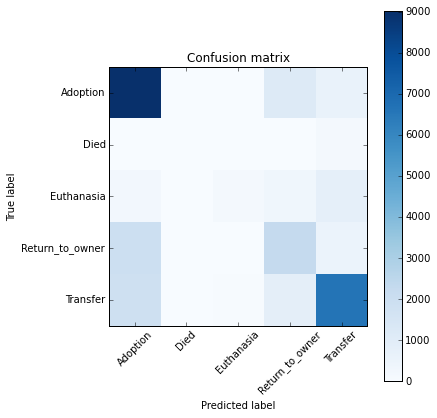

In [27]:
clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth=31)
fit_model(clf_rf)

Top features: 
['AgeYears' 'HasName[T.True]' 'AnimalType[T.Dog]:AgeYears'
 'Sex[T.Spayed Female]' 'Sex[T.Neutered Male]'
 'Sex[T.Spayed Female]:IsMix[T.True]' 'Sex[T.Neutered Male]:IsMix[T.True]'
 'AgeCategory[T.baby]' 'AnimalType[T.Dog]:HasName[T.True]'
 'Sex[T.Intact Male]' 'Sex[T.Intact Male]:IsMix[T.True]' 'Hour[T.17]'
 'Hour[T.18]' 'Color2[T.None]' 'Color2[T.White]' 'AmPm[T.PM]'
 'Color1[T.Black]' 'Color1[T.Brown]' 'WeekDay[T.Saturday]'
 'AnimalType[T.Dog]:Sex[T.Neutered Male]'
 'AnimalType[T.Dog]:Sex[T.Spayed Female]' 'AgeCategory[T.adolescent]'
 'Hour[T.09]' 'Hour[T.14]' 'WeekDay[T.Sunday]' 'WeekDay[T.Tuesday]'
 'Hour[T.15]' 'AgeCategory[T.adult]' 'AnimalType[T.Dog]:IsMix[T.True]'
 'Hour[T.13]' 'WeekDay[T.Monday]' 'Hour[T.12]'
 'Breed1[T.Domestic Shorthair]' 'Season[T.3-autumn]' 'WeekDay[T.Wednesday]'
 'Hour[T.11]' 'AnimalType[T.Dog]' 'WeekDay[T.Thursday]' 'Color1[T.White]'
 'Hour[T.16]' 'Breed1[T.Pit Bull]' 'Season[T.4-winter]'
 'Season[T.2-summer]' 'Sex[T.Unknown]' 'Color1[T.B

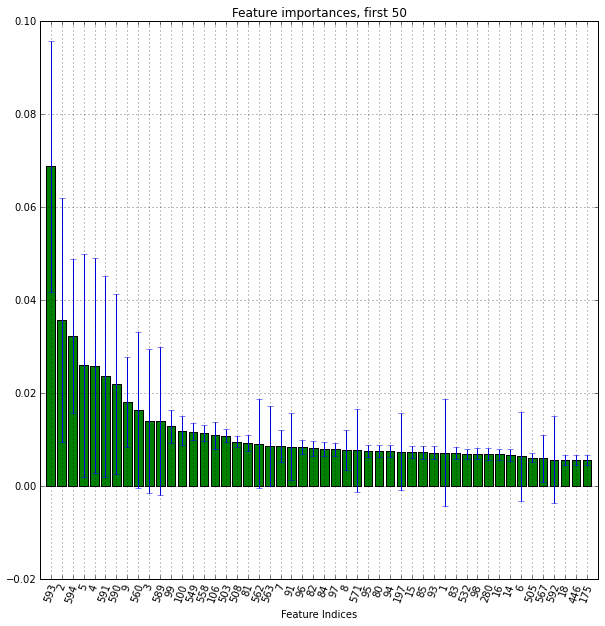

In [29]:
draw_rf_importances(clf_rf)

### Retrain with entire dataset, classify submission data, and prepare submission

In [ ]:
y_pred_sub = clf_rf.fit(train_data, train_labels).predict_proba(test_data)

In [ ]:
sub = pd.DataFrame(y_pred_sub, columns=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
sub.insert(0, 'ID', test.ID.astype(int))

In [ ]:
sub.head()

In [ ]:
sub.to_csv("submission_final.csv", index=False)